# Project 2 : Diabetes Patients Prediction

The objective of this analysis is to diagnostically predict whether a patient has diabetes based on certain diagnostic measurements. All patients here are females at least 21 years old.

# Loading libraries and data

In [1]:
# Library required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score 
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier

In [2]:
# Let's import our data
patients = pd.read_csv("D:\My files\MeriSkill\Project 2 - Diabetes Data\diabetes.csv")

# Exploratory Analysis & Pre-processing

In [3]:
patients

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Let's describe 9 variables:

- Pregnancies : Number of times of pregnancies 
- Glucose : Glucose concentration in the plasma
- BloodPressure : Blood pressure 
- SkinThickness : Thickness
- Insulin :Serum Insulin 
- BMI : Body Mass Index
- DiabetesPedigreeFunction : Inform on the strengh of presence of diabete in the family of patient
- Age : Age of patient
- Outcome : binary variable taking 1 if patient have diabete and 0 if not


#### Informations on the dataset

In [4]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
patients.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We remark like minimal values the digit 0 for variables "Glucose", "BloodPressure", "SkinThickness", "Insulin" and "BMI". These values are surprising because theses measures can not be equal to 0 for a living people. Then, we can deduce that 0 is put to meaning a missing value. 

In [6]:
patients['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Among the patients, 268 have diabete against 500 who have not diabete. Approximatively 35% of the patients have diabete against 65% who have not.

#### Checking of missing values

In [7]:
patients.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

There are not missing values in our dataset if we based ourselves on the empty cells. Seen, the presence of zero in the variables whose we talked about most above in the script, means missing values. Thus, we need to do a short transformation in our dataset to have these missing values.

In [8]:
# Transformation of null values by missing values 'nan'
Var=['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] # selection of variables of interest
patients[Var]=patients[Var].replace(0,np.nan)

In [9]:
patients.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

We remark missing values in our dataset. We are going proceed to their imputation.

In [10]:
# Let's compute median for each interest variable based on the modalities of variable 'Outcome'

patients.groupby('Outcome')['Glucose'].median()
# We find 107 like median for Glucose for patients who have not diabete and 140 for those who have not.
med_0_gluc=107
med_1_gluc=140

patients.groupby('Outcome')['BloodPressure'].median()
# We find 70 like median for BloodPressure for patients who have not diabete and 74.5 for those who have not.
med_0_BP=70
med_1_BP=74.5

patients.groupby('Outcome')['SkinThickness'].median()
# We find 27 like median for SkinThickness for patients who have not diabete and 32 for those who have not.
med_0_ST=27
med_1_ST=32

patients.groupby('Outcome')['Insulin'].median()
# We find 102.5 like median for Insulin for patients who have not diabete and 169.5 for those who have not.
med_0_Ins=102.5
med_1_Ins=169.5

patients.groupby('Outcome')['BMI'].median()
# We find 30.1 like median for BMI for patients who have not diabete and 34.3 for those who have not.
med_0_BMI=30.1
med_1_BMI=34.3

#### Imputation

In [11]:
# Let's proceed to the imputation by the median based on the class of patient

for i in patients['Outcome']:
    if i==0:
        patients['Glucose']=patients['Glucose'].fillna(med_0_gluc)
    else:
        patients['Glucose']=patients['Glucose'].fillna(med_1_gluc)

for i in patients['Outcome']:
    if i==0:
        patients['BloodPressure']=patients['BloodPressure'].fillna(med_0_BP)
    else:
        patients['BloodPressure']=patients['BloodPressure'].fillna(med_1_BP)

for i in patients['Outcome']:
    if i==0:
        patients['SkinThickness']=patients['SkinThickness'].fillna(med_0_ST)
    else:
        patients['SkinThickness']=patients['SkinThickness'].fillna(med_1_ST)

for i in patients['Outcome']:
    if i==0:
        patients['Insulin']=patients['Insulin'].fillna(med_0_Ins)
    else:
        patients['Insulin']=patients['Insulin'].fillna(med_1_Ins)

for i in patients['Outcome']:
    if i==0:
        patients['BMI']=patients['BMI'].fillna(med_0_BMI)
    else:
        patients['BMI']=patients['BMI'].fillna(med_1_BMI) 

In [12]:
patients.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

We remark now that there not exist missing values in the dataset.

### Visualization

##### Histogram

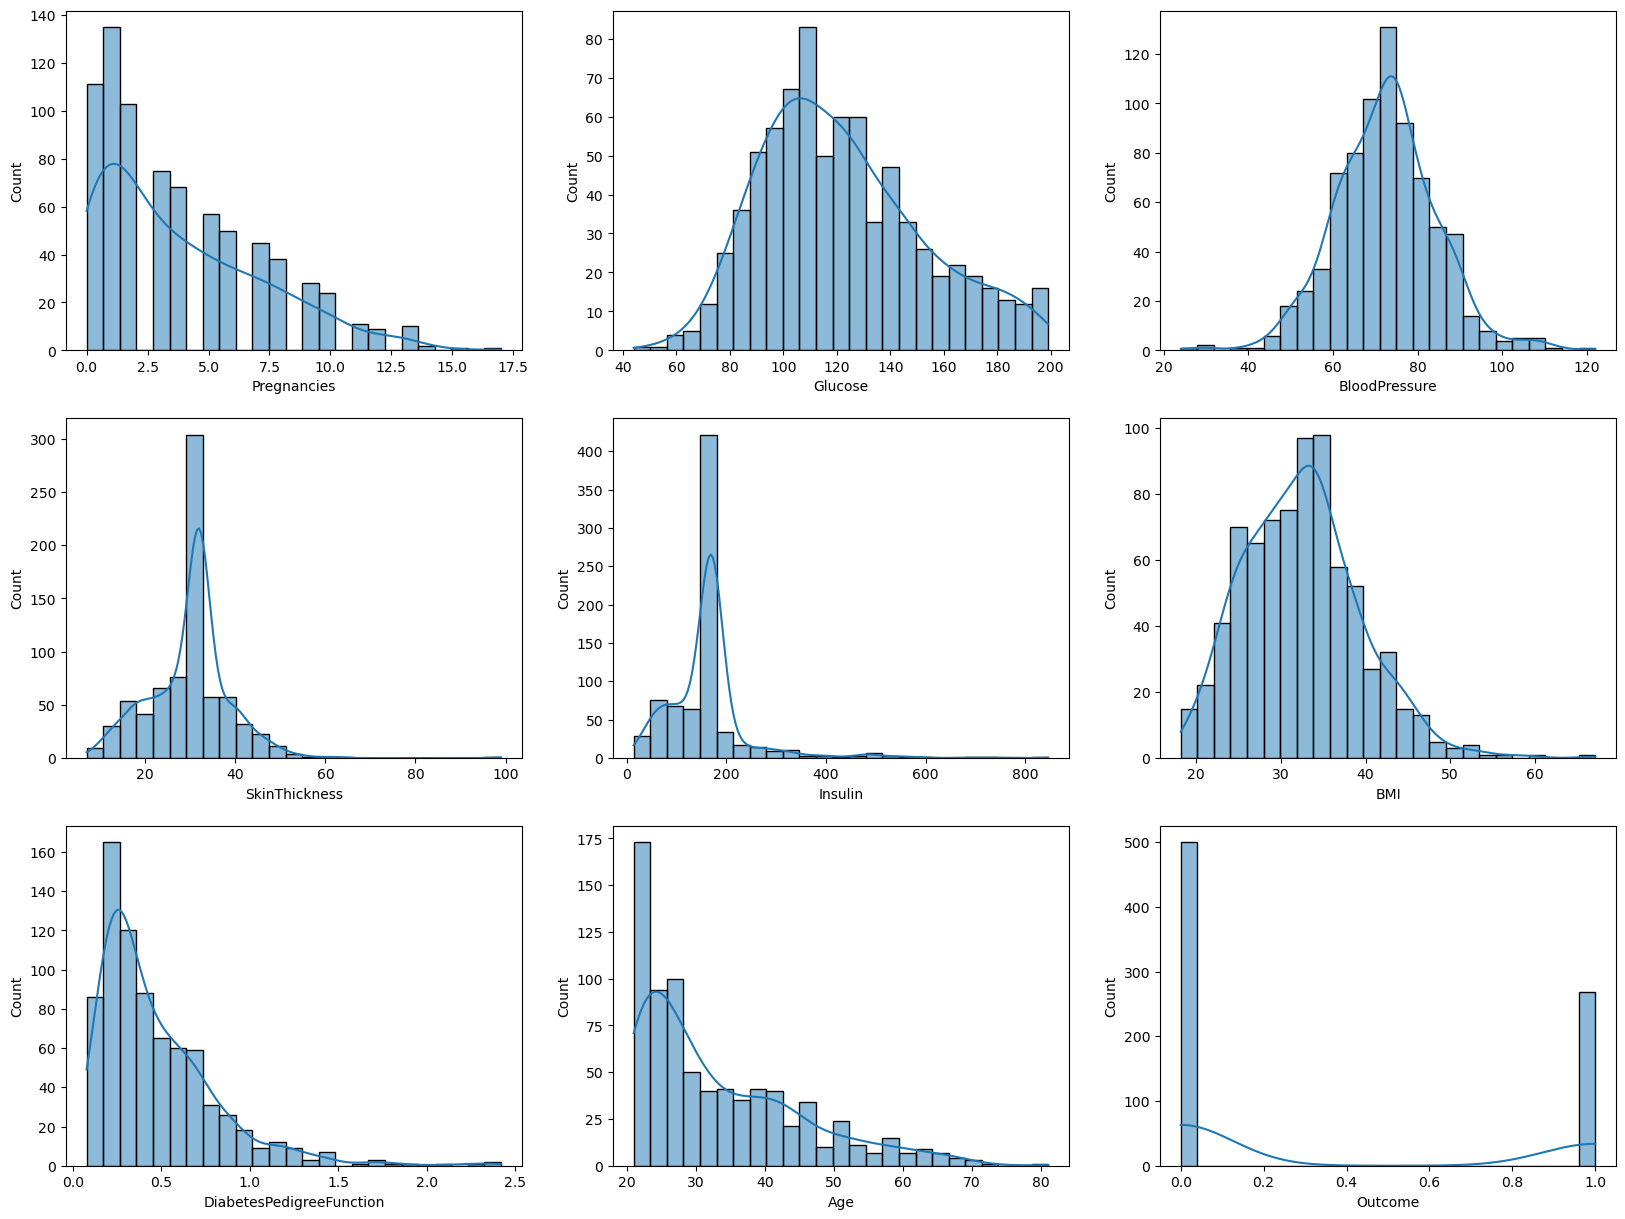

In [13]:
z=list(range(1,10))
plt.figure(figsize=(20,15))
for i, j in zip(patients.columns,z):
    plt.subplot(3,3,j)
    sns.histplot(patients[i],bins=25,kde=True)
    plt.xlabel(i)
    plt.ylabel('Count')

After visualization, we notice that only histogram of Glucose and BloodPressure have distribution almost normal.

##### Boxplots

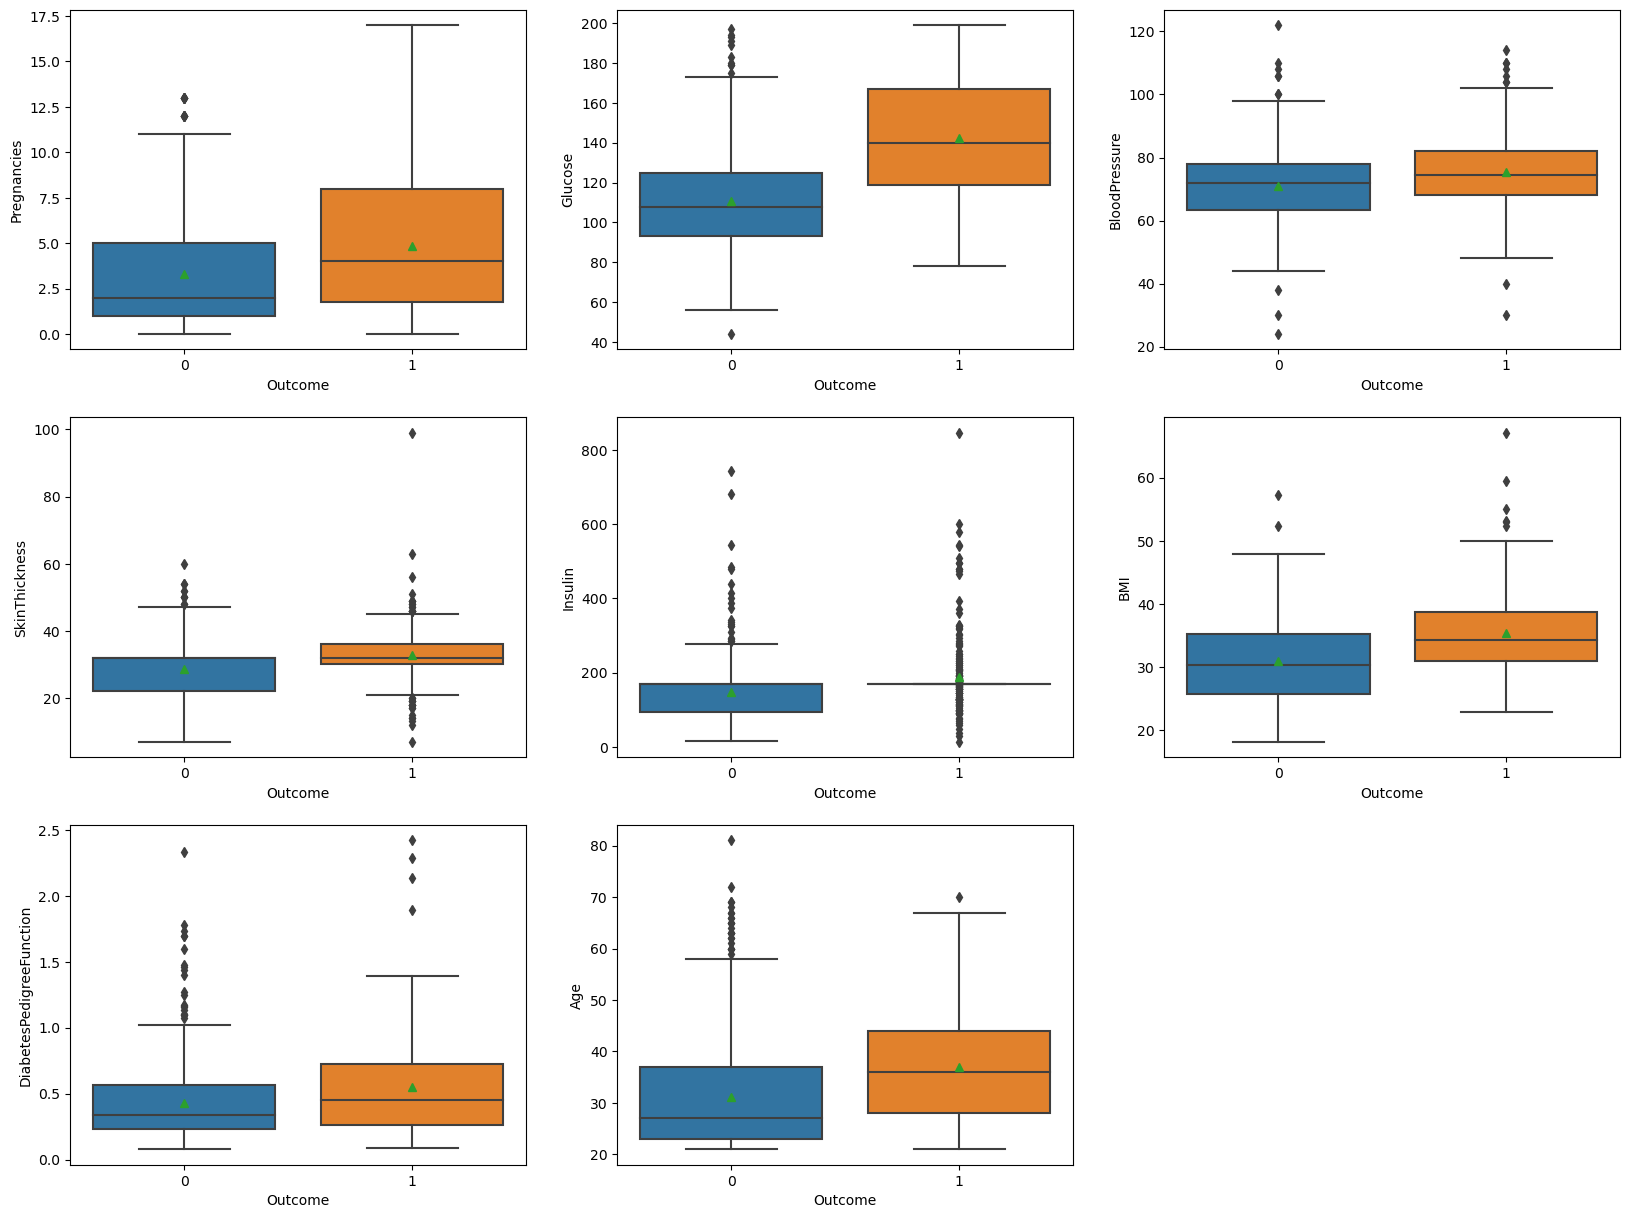

In [14]:
#Boxplots
plt.figure(figsize=(20,15))
for i,j in zip(patients.columns.drop('Outcome'),z):
    plt.subplot(3,3,j)
    sns.boxplot(x='Outcome',y=i,data=patients,showmeans=True)

We notice that diabetic patients have high mean in Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction and Age than none diabetic patients. We notice also a lot of outliers for Insulin, DiabetesPedigreeFunction and BloodPressure.

##### Correlation

In [15]:
patients.corr().style.background_gradient()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.126547,0.207879,0.104428,0.069758,0.021627,-0.033523,0.544341,0.221898
Glucose,0.126547,1.000000,0.215376,0.196002,0.414687,0.228584,0.135815,0.264676,0.492770
BloodPressure,0.207879,0.215376,1.000000,0.209662,0.085038,0.281826,-0.004751,0.322686,0.167757
SkinThickness,0.104428,0.196002,0.209662,1.000000,0.164311,0.522110,0.077395,0.158825,0.220678
Insulin,0.069758,0.414687,0.085038,0.164311,1.000000,0.158443,0.084695,0.153608,0.217041
BMI,0.021627,0.228584,0.281826,0.522110,0.158443,1.000000,0.152875,0.024596,0.310420
DiabetesPedigreeFunction,-0.033523,0.135815,-0.004751,0.077395,0.084695,0.152875,1.000000,0.033561,0.173844
Age,0.544341,0.264676,0.322686,0.158825,0.153608,0.024596,0.033561,1.000000,0.238356
Outcome,0.221898,0.492770,0.167757,0.220678,0.217041,0.310420,0.173844,0.238356,1.000000


We notice correlation no null between all explanatory variables and dependant variable(Outcome). This explains that they can explain the behaviour of the dependant variable. Between explanatory variables, we notice correlations taht are not so high. This explains that we won't have problem of multicolinearity if we use them in our modelling. The strongest correlation between these variables is 0.54 and it's the correlation coefficient betwen Age and Pregnancies.   

## Modeling

#### Splitting the dataset

We are going use the ratio 70% and 30% for split our dataset. 70% for our train set and 30% for our test set.  
######## At starting, I used 80% against 20%. In order to avoid overfitting, I changed after for 70% against 30%.

In [16]:
# Let X our set of explanatory variables and Y our dependant variable
X=patients.drop('Outcome',axis=1)
Y=patients['Outcome']

# Splitting
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,shuffle=True,random_state=50)
print("X_train.shape:", X_train.shape,";", "X_test.shape:", X_test.shape)

X_train.shape: (537, 8) ; X_test.shape: (231, 8)


The dependant variable being binary variable, we'll use Logistic regression model.

##### Logistic Regression

In [17]:
Model=LogisticRegression(max_iter=1000,random_state=50,class_weight={0:0.65,1:0.35})
Model.fit(X_train,Y_train)
Y_pred=Model.predict(X_test)
print("accuracy_score:",accuracy_score(Y_test,Y_pred))
print("parameters of model:",Model.get_params())

accuracy_score: 0.7532467532467533
parameters of model: {'C': 1.0, 'class_weight': {0: 0.65, 1: 0.35}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 50, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Our model have a precision score of 75% around.

##### Learning Curve

Learning Curve:


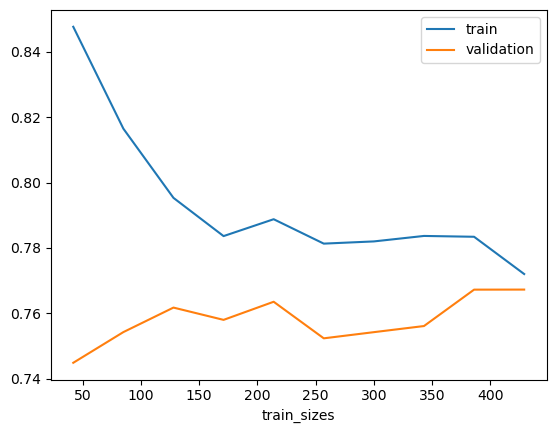

In [18]:
# Let's checking the learning curve
V, train_score, val_score = learning_curve(Model, X_train, Y_train, train_sizes=np.linspace(0.1,1,10),cv=5)
print("Learning Curve:")
plt.plot(V,train_score.mean(axis=1),label='train')
plt.plot(V,val_score.mean(axis=1),label='validation')
plt.xlabel('train_sizes')
plt.legend()

#### Confusion Matrix

In [19]:
confusion_matrix(Y_test,Y_pred)

array([[141,   7],
       [ 50,  33]], dtype=int64)

We find that our model is able to make the following predictions:    
- Among 148 non diabetic patients, 141 have been well disposed in the class of non diabetic and 7 have been disposed in the bad class. This make 95.27% of success for this class 
- Among 83 diabetic patients, 33 have been well disposed in the class of diabetic against 50 in the bad class. This make 40% of success for this class.  


 __We are going try to find the hyperparameters that will might increase these scores__

##### Handling of hyperparameters for Logistic Regression

In [20]:
# definition of hyperparameters
param= {'C':np.logspace(-4, 4, 10),
        'solver':['liblinear','saga'],
       'max_iter':[100,500,1000,10000],'penalty':['l1','l2']
       }

cv=StratifiedKFold(5) # I used that because I want give chance to each class to belong each split

grid=GridSearchCV(LogisticRegression(random_state=50,class_weight={0:0.65,1:0.35}),param,cv=cv,scoring='accuracy')

grid.fit(X_train,Y_train)
Mod=grid.best_estimator_
Y_pred=Mod.predict(X_test)

print("Best_param:", grid.best_params_)
print("parameters of model","are",Mod.get_params())
print("Best_score:", grid.best_score_)
print("accuracy:", accuracy_score(Y_test,Y_pred))
print(" ")
print("Confusion Matrix:")
confusion_matrix(Y_test,Y_pred)

Best_param: {'C': 166.81005372000558, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
parameters of model are {'C': 166.81005372000558, 'class_weight': {0: 0.65, 1: 0.35}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 50, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best_score: 0.7691415714780201
accuracy: 0.7532467532467533
 
Confusion Matrix:


array([[141,   7],
       [ 50,  33]], dtype=int64)

##### Learning Curve

Learning curve


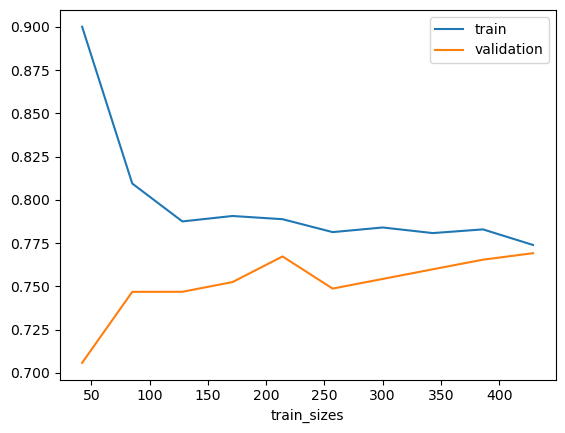

In [21]:
V, train_score, val_score = learning_curve(Mod, X_train, Y_train, train_sizes=np.linspace(0.1,1,10),cv=5)
print("Learning curve")
plt.plot(V,train_score.mean(axis=1),label='train')
plt.plot(V,val_score.mean(axis=1),label='validation')
plt.xlabel('train_sizes')
plt.legend()

Despite our hyper-parametrization, we were unable to significantly increase accuracy compared to the original model. We're now at around 76%. We're going to try other classification models.

#### Others classification models

In [22]:
r=[AdaBoostClassifier(random_state=50),RandomForestClassifier(random_state=50),ExtraTreesClassifier(random_state=50),BaggingClassifier(random_state=50)]
for i in r:
    Model=i
    Model.fit(X_train,Y_train)
    Y_pred=Model.predict(X_test)
    print("Accuracy_score of",str(i),"is",accuracy_score(Y_test,Y_pred))
    print("The parameters of model",str(i),"are:",Model.get_params())
    print(confusion_matrix(Y_test,Y_pred))
    print("\n")

Accuracy_score of AdaBoostClassifier(random_state=50) is 0.7402597402597403
The parameters of model AdaBoostClassifier(random_state=50) are: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 50}
[[122  26]
 [ 34  49]]


Accuracy_score of RandomForestClassifier(random_state=50) is 0.7792207792207793
The parameters of model RandomForestClassifier(random_state=50) are: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 50, 'verbose': 0, 'warm_start': False}
[[132  16]
 [ 35  48]]


Accuracy_score of ExtraTreesClassifier(random_state=50) is 0.7705627705627706
The parameters of model ExtraTreesClassifier(random_s

We notice that RandomForestClassifier give a best accuracy. We are going try to handle his hyperparameters.

##### Handling of hyperparameters of RandomForestClassifier

In [23]:
# definition of hyperparameters
param= {'n_estimators':[25,50,100],
       'max_depth':[2,3,5],
       'min_samples_split':[2,5,8],
       'min_samples_leaf':[1,2,3],
       'max_features':['auto','sqrt','log2'],
       'bootstrap':[True,False]}

cv=StratifiedKFold(5) # I used that because I want give chance to each class to belong each split

grid=GridSearchCV(RandomForestClassifier(random_state=50,class_weight={0:0.65,1:0.35}),param,cv=cv,scoring='accuracy')

grid.fit(X_train,Y_train)
Mod=grid.best_estimator_
Y_pred=Mod.predict(X_test)

print("Best_param:", grid.best_params_)
print("parameters of model","are",Mod.get_params())
print("Best_score:", grid.best_score_)
print("accuracy:", accuracy_score(Y_test,Y_pred))
print(" ")
print("Confusion Matrix:")
confusion_matrix(Y_test,Y_pred)

Best_param: {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
parameters of model are {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 0.65, 1: 0.35}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 50, 'verbose': 0, 'warm_start': False}
Best_score: 0.7728452751817237
accuracy: 0.7575757575757576
 
Confusion Matrix:


array([[139,   9],
       [ 47,  36]], dtype=int64)

The handling of hyperparameters hasn't improved the accuracy of prediction compared to RandomForestClassifier of the starting. We are going keep the hyperparameters of model of starting.

## Conclusion

In order to predict whether a patient has diabete or no, we used variables that have been provided. We used some classification models in order to see those which give best accuracy of precision. The best are LogisticRegressionClassifier and RandomForestClassifier that have respectively __75%__ and __78%__ of accuracy. The confusion matrix have us provided how the model cheat itself to make prediction. We noticed that the __logistic regression model have a percent of 95.27% of success to predict patients who have no diabete against 40% of success to predict those who have not__. Whereas __Random Forest have a percent of 89% of success to predict patients who have no diabete against 58% of success to predict those who have not__. The handling of hyperparameters for each model have not improve significantly the accuracy score. We deduced that the high percent for the detection of patients who have not diabete by our models is based on the big sample of patients who have not diabete in the dataset. Also, the big quantity of missing values for interest variables like 'Insulin'(49%) and 'SkinThickness'(30%) have been a handicap. We think still that the accuracy score for the prediction can be improved if the new data with good measures of interest variables are us provided.
